In [1]:
# Source: https://www.kaggle.com/tcvieira/titanic-decision-tree
# Import modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split

# Figures inline and set visualization style
%matplotlib inline
sns.set()

In [3]:
# Load data
df_train = pd.read_csv('titanictreetrain.csv')
df_test = pd.read_csv('titanictreetest.csv')

In [4]:
print(df_train.shape)
df_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


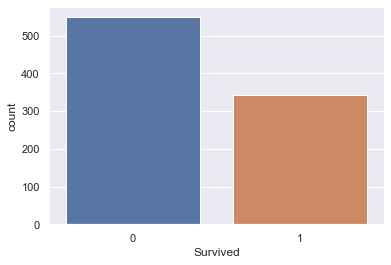

In [6]:
# Basic EDA
sns.countplot(x='Survived', data=df_train);

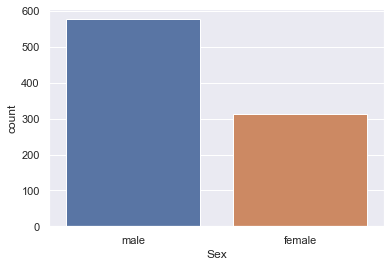

In [7]:
sns.countplot(x='Sex', data=df_train);

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


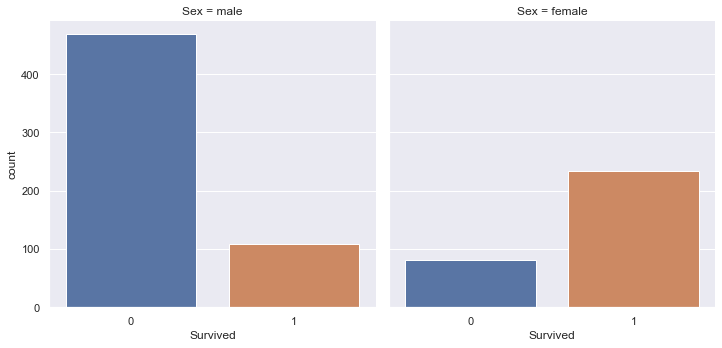

In [8]:
# Plot genderwise survival
sns.factorplot(x='Survived', col='Sex', kind='count', data=df_train);

In [9]:
# Count gender vs. survival
df_train.groupby(['Sex']).Survived.sum()

Sex
female    233
male      109
Name: Survived, dtype: int64

In [10]:
# Proportion of women that survived and the proportion of men
print(df_train[df_train.Sex == 'female'].Survived.sum()/df_train[df_train.Sex == 'female'].Survived.count())
print(df_train[df_train.Sex == 'male'].Survived.sum()/df_train[df_train.Sex == 'male'].Survived.count())

0.7420382165605095
0.18890814558058924


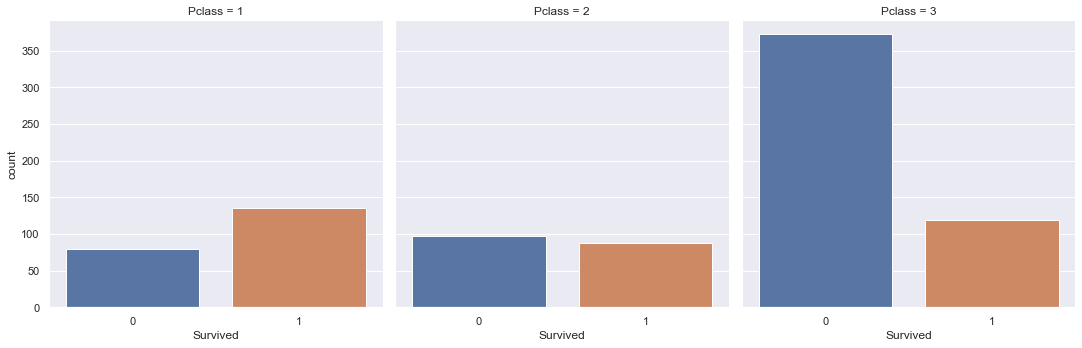

In [11]:
# Check Survival by passenger class
sns.factorplot(x='Survived', col='Pclass', kind='count', data=df_train);

Passengers that travelled in first class were more likely to survive. On the other hand, passengers travelling in third class were more unlikely to survive.

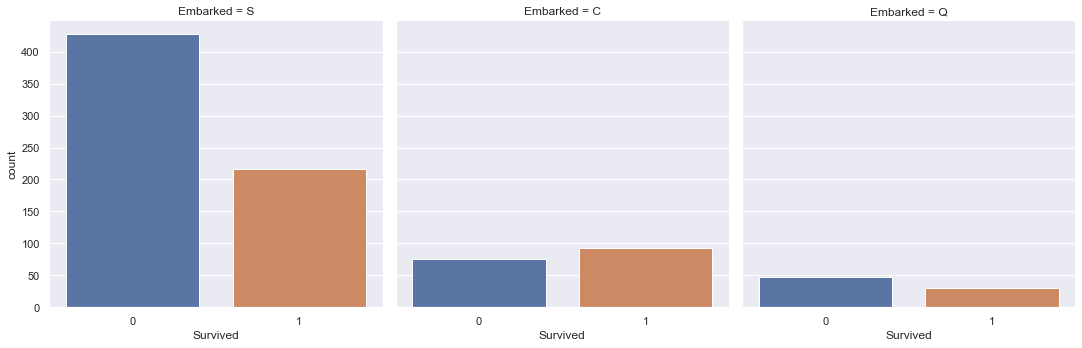

In [12]:
# Check port of embarkation S, C or O
sns.factorplot(x='Survived', col='Embarked', kind='count', data=df_train);

Passengers that embarked in Southampton were less likely to survive

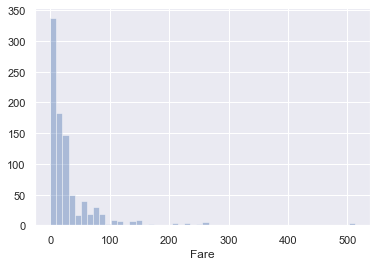

In [13]:
# Check distribution of fare
sns.distplot(df_train.Fare, kde=False);

Most passengers paid less than 100 for travelling with the Titanic.

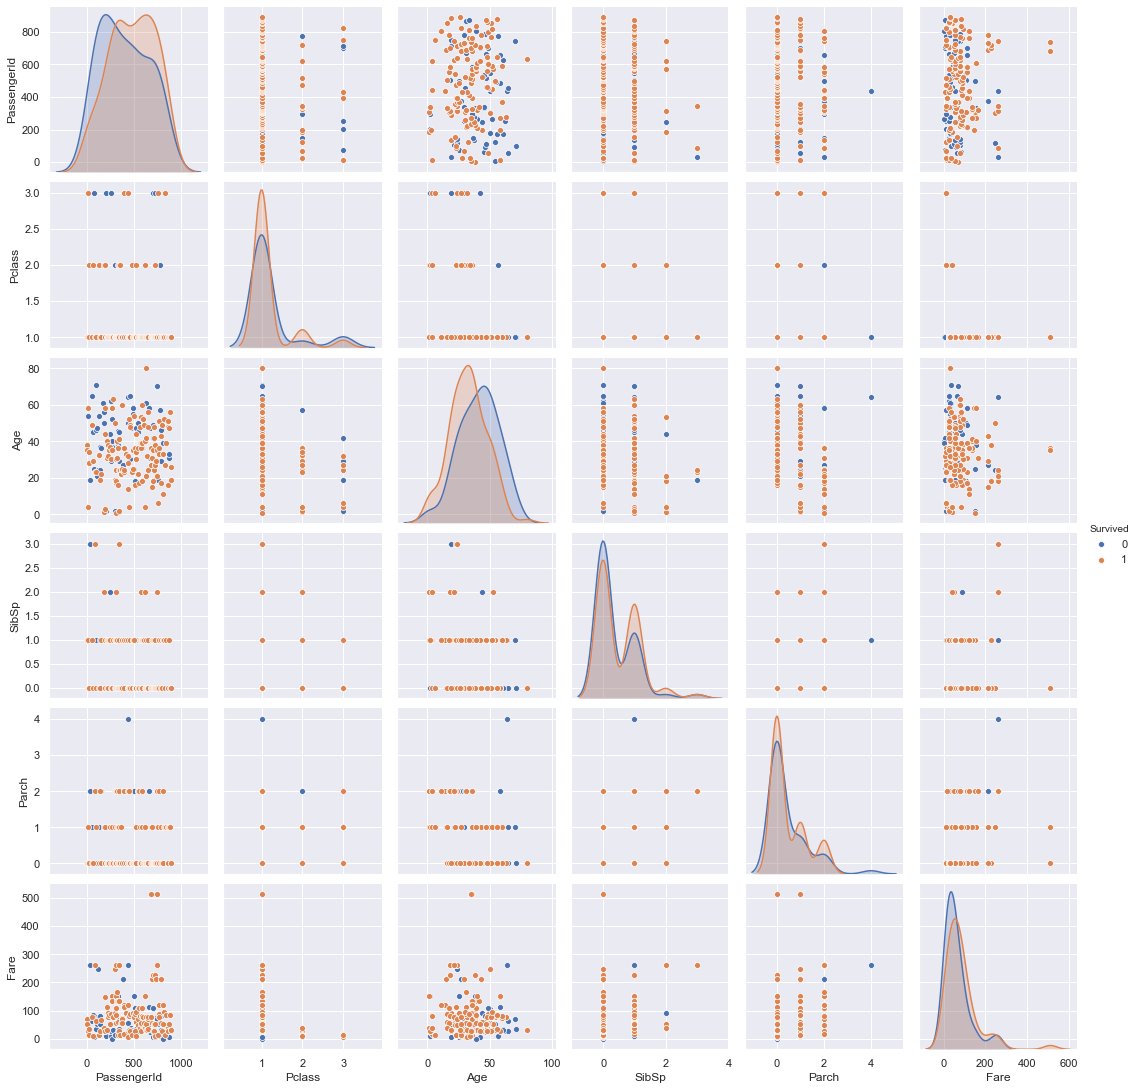

In [14]:
# Visualise with pairplot (correlation)
df_train_drop = df_train.dropna()
sns.pairplot(df_train_drop, hue='Survived');

### Data Wrangling / Data Cleaning

In [22]:
# Store target variable of training data in a safe place
survived_train = df_train.Survived

# Concatenate training and test sets
data = pd.concat([df_train.drop(['Survived'], axis=1), df_test])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [23]:
# Fill missing numerical variables Age & Fare with median values of Age & Fare
data['Age'] = data.Age.fillna(data.Age.median())
data['Fare'] = data.Fare.fillna(data.Fare.median())

# Check out info of data if there is any null data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 122.7+ KB


In [24]:
# Tranform Sex feature to numeric value
# create a new column for each of the options in 'Sex'
# creates a new column for female, called 'Sex_female', but drops this first column
# creates a new column for 'Sex_male'
# more then two categorical values it is better to use one-hot-encode
data = pd.get_dummies(data, columns=['Sex'], drop_first=True)
data.head()

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


In [25]:
# Select features columns
data = data[['Sex_male', 'Fare', 'Age','Pclass', 'SibSp']]
data.head()

,Sex_male,Fare,Age,Pclass,SibSp
0,1,7.2500,22.0,3,1
1,0,71.2833,38.0,1,1
2,0,7.9250,26.0,3,0
3,0,53.1000,35.0,1,1
4,1,8.0500,35.0,3,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 5 columns):
Sex_male    1309 non-null uint8
Fare        1309 non-null float64
Age         1309 non-null float64
Pclass      1309 non-null int64
SibSp       1309 non-null int64
dtypes: float64(2), int64(2), uint8(1)
memory usage: 52.4 KB


In [27]:
# split it back into training and test sets
data_train = data.iloc[:891]
data_test = data.iloc[891:]

In [28]:
# scikit-learn requires the data as arrays
X = data_train.values
test = data_test.values
y = survived_train.values

In [31]:
# Instantiate model and fit to data
clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier()

### Visualise this decision tree and Gini coefficients using graphviz

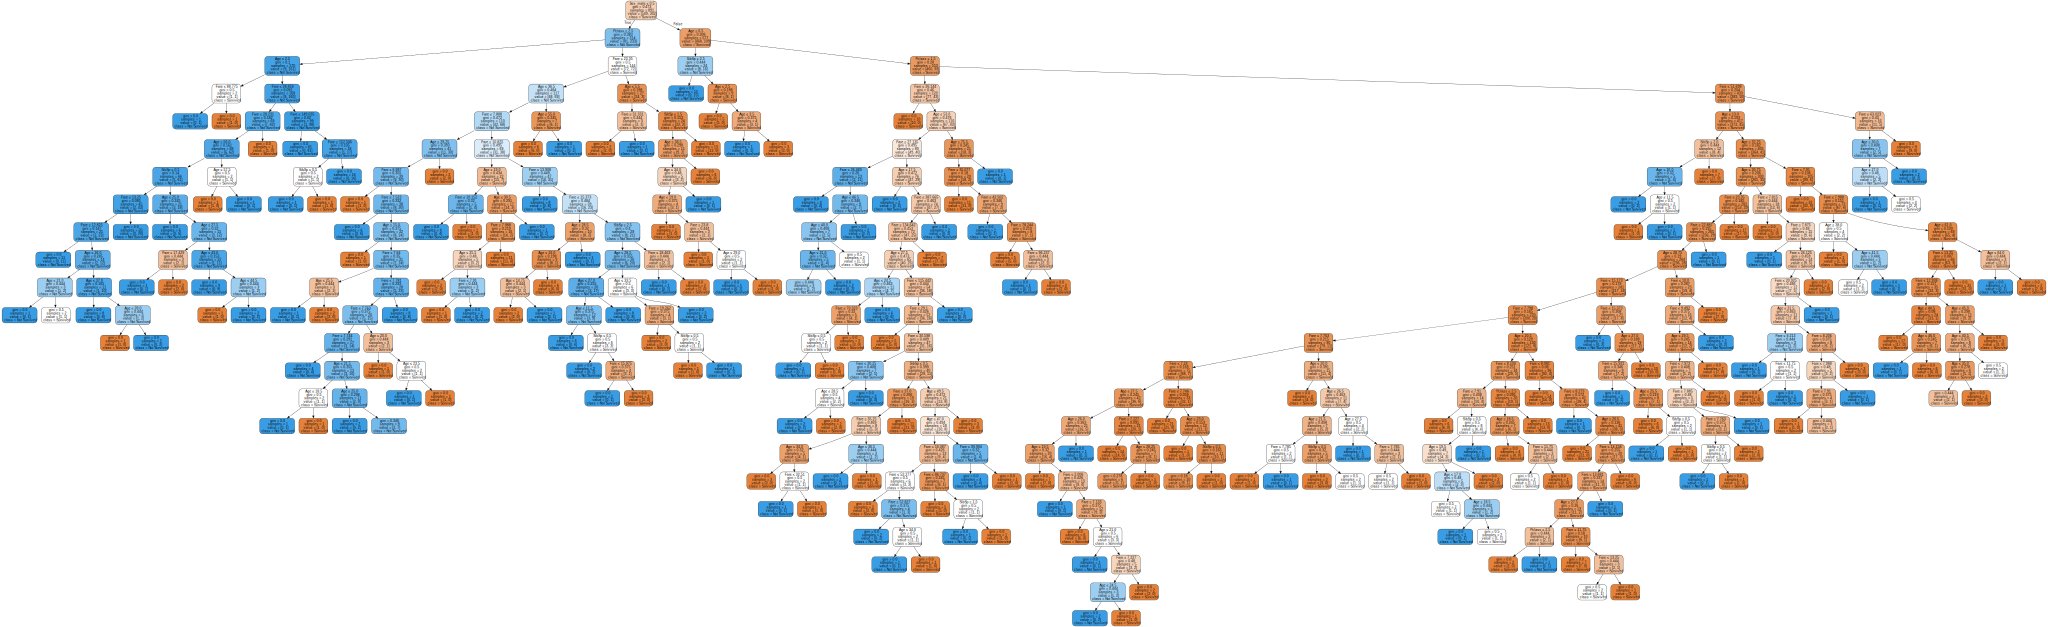

In [36]:
import graphviz 
#dot_data = tree.export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("Titanic") 

dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=data_train.columns.values,  
                         class_names=['Survived','Not Survived'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)   
graph